In [231]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt#
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import sys
sys.path.append("/Users/marcsauer/PycharmProjects/Swim/src/")
from preprocessing import Preprocessing
import glob

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [214]:
testrun = 'first_model_logreg'
pre = Preprocessing(testrun)

Creating "first_model_logreg" directory for you!


In [29]:
# Load data
raw_accel = pre.load_data('accel-175130000657-20190405T093805Z.csv', name='raw_accel', header=None)
raw_gyro = pre.load_data('gyro-175130000657-20190405T093806Z.csv', name='raw_gyro', header=None)
raw_magn = pre.load_data('magn-175130000657-20190405T093805Z.csv', name='raw_magn', header=None)

In [30]:
# Create data frame with all sensor information
column_names = ['Accel_X', 'Accel_Y', 'Accel_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'Magn_X', 'Magn_Y', 'Magn_Z']
raw_data = pd.concat([raw_accel, raw_gyro, raw_magn], axis=1, sort=False)
raw_data.columns = column_names
raw_data.head(5)

,Accel_X,Accel_Y,Accel_Z,Gyro_X,Gyro_Y,Gyro_Z,Magn_X,Magn_Y,Magn_Z
0,-3.254355,2.110545,-9.016478,-2.38,0.49,2.31,-67.950005,-58.200001,165.450012
1,-3.062922,2.024400,-8.978191,1.12,2.10,2.94,-69.150002,-58.650002,163.950012
2,-3.306999,1.876040,-8.959048,0.00,0.14,2.80,-67.950005,-56.850002,165.150009
3,-3.007885,1.713322,-9.375414,-5.25,0.21,-2.31,-67.950005,-60.600002,165.600006
4,-3.326142,1.718108,-9.404129,-4.41,4.55,-6.09,-66.900002,-59.400002,164.100006


In [31]:
raw_data.shape

(4105, 9)

<IPython.core.display.Javascript object>


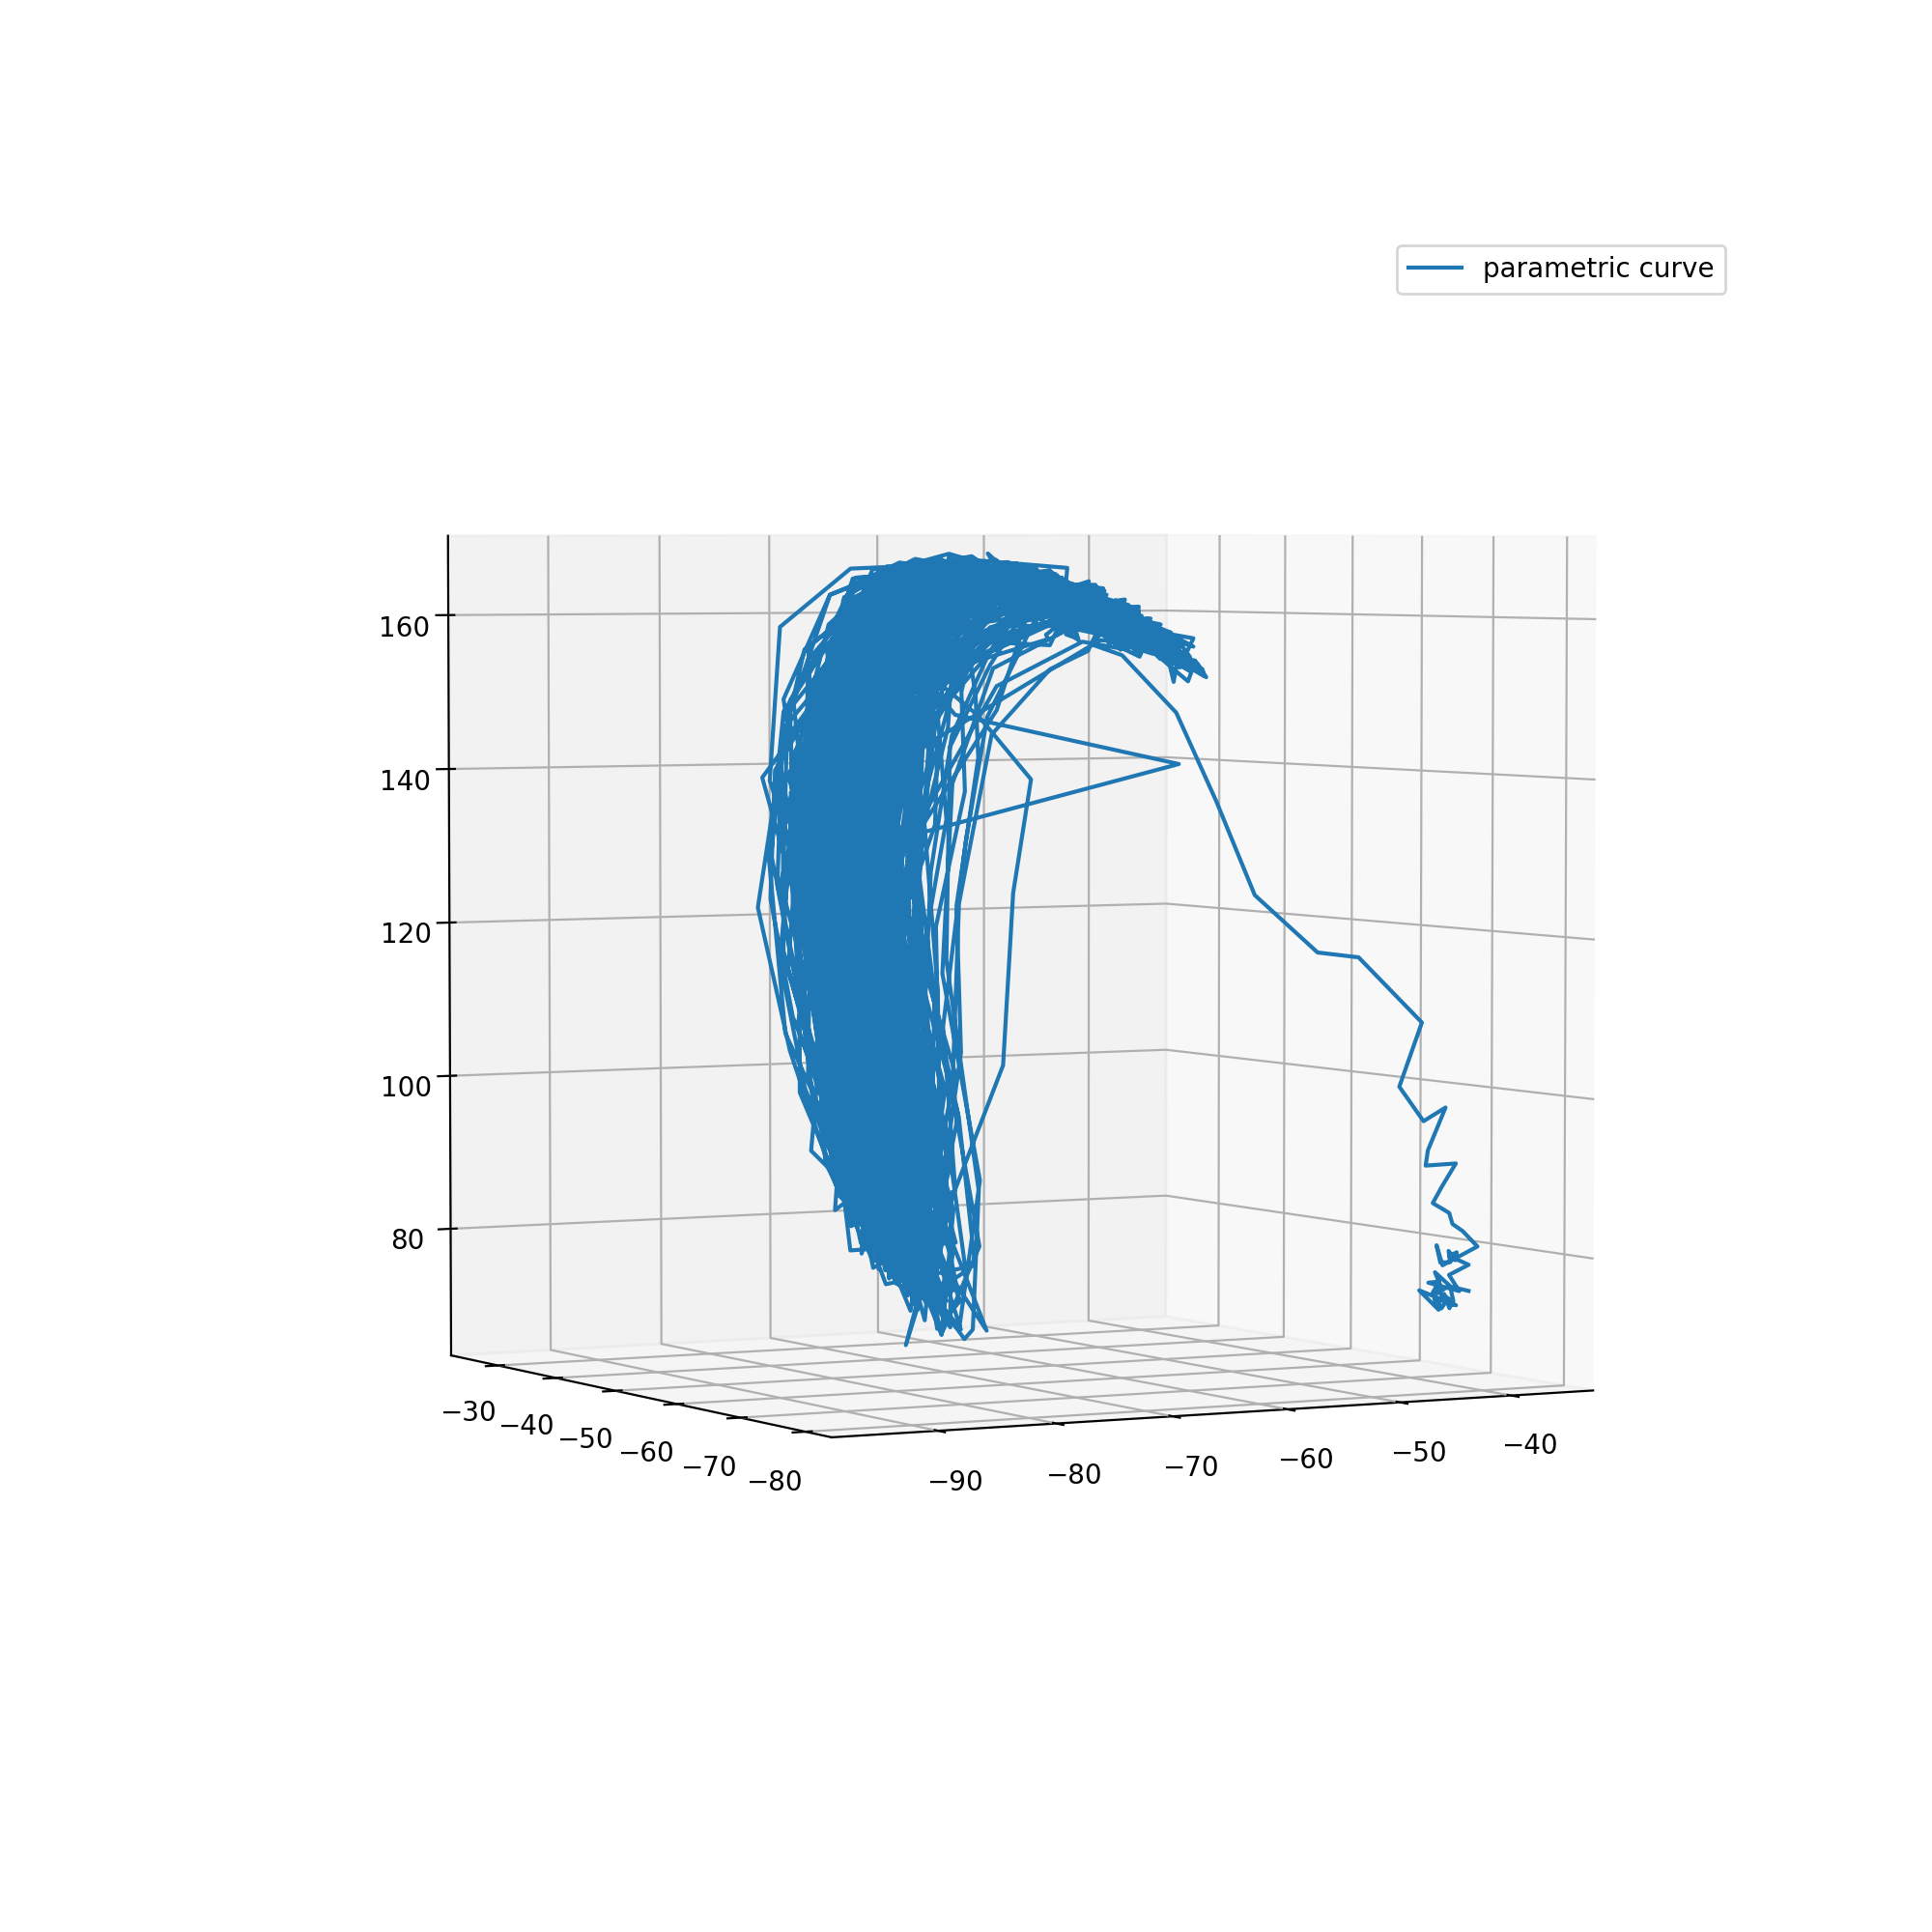

In [191]:
# Plot data (13 Hz)
fig = plt.figure(10, figsize= (10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(raw_data['Magn_X'], raw_data['Magn_Y'], raw_data['Magn_Z'], label='parametric curve')
ax.legend()
plt.show()

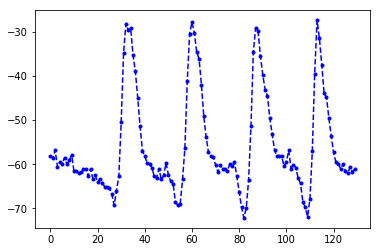

In [33]:
# plt.plot(raw_all[:60].index, raw_all[:60]['Magn_X'])
plt.plot(raw_data[:130].index, raw_data[:130]['Magn_Y'],'b.--')
# plt.plot(raw_all[:60].index, raw_all[:60]['Magn_Z'])

# plt.plot(raw_all[60:120].index, raw_all[60:120]['Magn_X'])
# plt.plot(raw_all[60:120].index, raw_all[60:120]['Magn_Y'])
# plt.plot(raw_all[60:120].index, raw_all[60:120]['Magn_Z'])
# 

plt.show()

# Preprocessing

In [34]:
# Define stroke cut
Magn_Y_max = raw_data['Magn_Y'].max()
Magn_Y_min = raw_data['Magn_Y'].min()
min_max_range = Magn_Y_max-Magn_Y_min
stroke_cut = Magn_Y_max-(min_max_range*.25)
print(stroke_cut)

-39.22500275


In [131]:
# Create data frame for every single stroke
def single_stroke(raw_data, testrun):
    # Define stroke cut
    Magn_Y_max = raw_data['Magn_Y'].max()
    Magn_Y_min = raw_data['Magn_Y'].min()
    min_max_range = Magn_Y_max-Magn_Y_min
    stroke_cut = Magn_Y_max-(min_max_range*.25)
    
    # Cut stroke
    single_stroke_end = []
    for i in range(0,len(raw_data['Magn_Y'])):
        if (raw_data['Magn_Y'][i] > stroke_cut) == True and (raw_data['Magn_Y'][i-1] < stroke_cut) == True:
            single_stroke_end.append(i)
    
    # Create list of data frames
    single_stroke_end_mod = [-1] + single_stroke_end
    list_of_dfs = [raw_data.iloc[single_stroke_end_mod[n]+1:single_stroke_end_mod[n+1]+1] for n in range(len(single_stroke_end_mod)-1)]
    
    # Save single strokes to csv
    k = 1
    for i in range(0, len(list_of_dfs)):
        pd.DataFrame(list_of_dfs[i]).to_csv('/Users/marcsauer/PycharmProjects/Swim/data/{}/stroke_{}.csv'.format(testrun, k), index=False)
        k += 1

In [59]:
single_stroke_0_1_50 = pd.read_csv('/Users/marcsauer/PycharmProjects/Swim/data/Run_0_1/stroke_50.csv')
single_stroke_1_1_50 = pd.read_csv('/Users/marcsauer/PycharmProjects/Swim/data/Run_1_1/stroke_50.csv')

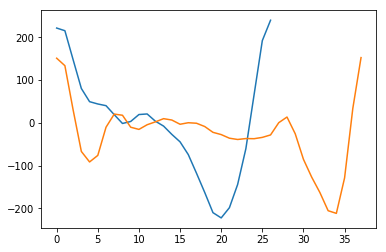

In [69]:
#plt.plot(single_stroke_99['Magn_Y'])
plt.plot(single_stroke_0_1_50['Gyro_Y'])
plt.plot(single_stroke_1_1_50['Gyro_Y'])
plt.show()

In [70]:
Magn_Y_mean = single_stroke_0_1_50["Gyro_Y"].mean()
Magn_Y_min = single_stroke_0_1_50["Gyro_Y"].min()
Magn_Y_max = single_stroke_0_1_50["Gyro_Y"].max()
print('Mean: '+str(Magn_Y_mean))
print('Min: '+str(Magn_Y_min))
print('Max: '+str(Magn_Y_max))

Mean: 3.4403712962963
Min: -222.460007
Max: 240.100006


In [71]:
Magn_Y_mean = single_stroke_1_1_50["Gyro_Y"].mean()
Magn_Y_min = single_stroke_1_1_50["Gyro_Y"].min()
Magn_Y_max = single_stroke_1_1_50["Gyro_Y"].max()
print('Mean: '+str(Magn_Y_mean))
print('Min: '+str(Magn_Y_min))
print('Max: '+str(Magn_Y_max))

Mean: -24.275263289473692
Min: -211.820007
Max: 152.669998


## Feature engineering

In [200]:
condition_0 = '/Users/marcsauer/PycharmProjects/Swim/data/Run_0_*/stroke_*.csv'
condition_1 = '/Users/marcsauer/PycharmProjects/Swim/data/Run_1_*/stroke_*.csv'

In [201]:
def feature_dataframe(condition):
    '''Creating features from single stroke and merge into new data frame'''
    Magn_Y_mean = []
    Magn_Y_min = []
    Gyro_Y_mean = []
    
    # Load data
    for file in glob.glob(condition):
        single_stroke = pd.read_csv(file)
        
    # Preprocess data
        # Magn_Y_mean
        single_stroke_magn_y_mean = single_stroke["Magn_Y"].mean()
        Magn_Y_mean.append(single_stroke_magn_y_mean)
        
        # Magn_Y_min
        single_stroke_magn_y_min = single_stroke["Magn_Y"].min()
        Magn_Y_min.append(single_stroke_magn_y_min)
        
        # Gyro_Y_mean
        single_stroke_gyro_y_mean = single_stroke["Gyro_Y"].mean()
        Gyro_Y_mean.append(single_stroke_gyro_y_mean)
        
    # Create new data frame
    feature_dataframe = pd.DataFrame({'Magn_Y_mean':Magn_Y_mean, 'Magn_Y_min':Magn_Y_min, 'Gyro_Y_mean':Gyro_Y_mean})    

    # Add condition to data frame
    if condition == condition_0:
        feature_dataframe['condition'] = 0
    elif condition == condition_1:
        feature_dataframe['condition'] = 1
    else:
        print('No condition as input') # nicht wirksam
    return feature_dataframe

In [210]:
# Create clean data
feature_df_0 = feature_dataframe(condition_0)
feature_df_1 = feature_dataframe(condition_1)

frames = [feature_df_0, feature_df_1]
feature_df_clean = pd.concat(frames)

# Train model

In [241]:
X = feature_df_clean.drop(['Magn_Y_min', 'Gyro_Y_mean', 'condition'], axis=1)
y = feature_df_clean['condition']

In [242]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [250]:
logreg = LogisticRegression(solver='liblinear', multi_class='ovr')
model_logreg = logreg.fit(X_train, y_train)

In [251]:
score_logreg = model_logreg.score(X_val, y_val)
print('Score Logistic Regression: {}%'.format(score_logreg*100))

Score Logistic Regression: 54.263565891472865%
